<a href="https://colab.research.google.com/github/cs23m066/DL-ASSIGNMENT/blob/main/DL_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np

In [6]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [ ]:
print(np.unique(test_labels))

[0 1 2 3 4 5 6 7 8 9]


In [ ]:
mySet = np.unique(train_labels)
myData  = []
count = 10
for train_image,train_label in zip(train_images,train_labels):
  if(train_label in mySet ):
    index = np.where(mySet == train_label)
    myData.append(train_image)
    mySet = np.delete(mySet,index)
    count-=1
  if(count == 0):
    break

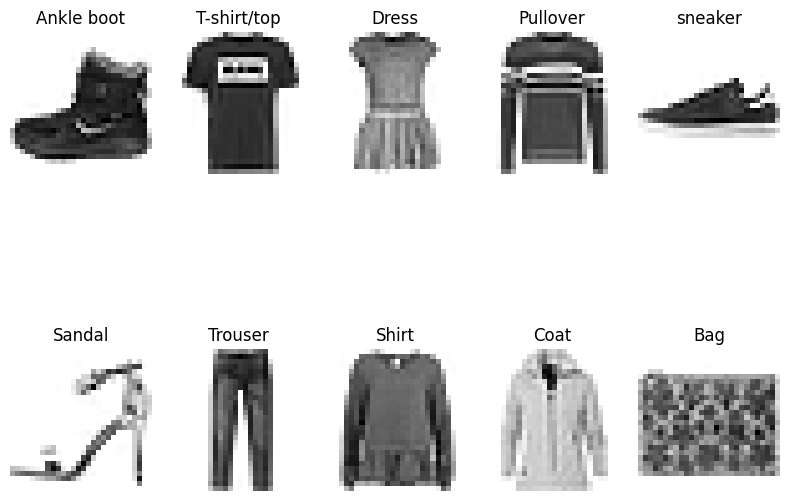

In [ ]:
names =['Ankle boot','T-shirt/top','Dress','Pullover','sneaker','Sandal','Trouser','Shirt','Coat','Bag']
fig, axes = plt.subplots(2, 5, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.set_title(names[i])
    ax.imshow(myData[i], cmap=plt.cm.binary)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [7]:
def _softmax(z):
  # res = []
  # sum = 0.0
  # for x in z:
  #   sum += np.exp(x)
  # for x in z:
  #   res.append(np.exp(x)/sum)
  # return np.array(res)
  eps = 1e-6
  return (np.exp(z-max(z)) / (sum(np.exp(z-max(z))) + eps))

In [5]:
z = np.array([1,1,1,1])
print(_softmax(z))
print(np.exp(1)/(np.exp(1)*4))

[0.24999994 0.24999994 0.24999994 0.24999994]
0.25


In [8]:
def _sigmoid(z):
  z = np.clip(z, -500, 500)
  return 1/(1+np.exp(-z))
  # return sigmoid_z

In [9]:
def _sigmoid_derivative(z):
  return _sigmoid(z) * (1 - _sigmoid(z))

In [7]:
z = np.array([1,2,3,4,5,6,7,8,9,10])
z= np.reshape(10,1)
print(_softmax(z).shape)

(1,)


In [10]:
def _tanh(z):
  clipped_z = np.clip(z, -50, 50)
  return np.tanh(clipped_z)

In [11]:
def _tanh_derivative(z):
  return 1-np.tanh(z)**2

In [12]:
def _relu(z):
  return np.maximum(0,z)

In [13]:
def _relu_derivative(z):
  return np.where(z>0,1,0)

In [12]:
e_l = np.ones((10,1))
print(_sigmoid_derivative(e_l).shape)

(10, 1)


In [17]:
e_l = np.zeros((10,1))
e_l[1,0] = 1
print(e_l)
e_l[2] = 1
print(e_l)

[[0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [14]:
def backwardPropogation(w,h,a,clas,n,train_image,activFunc):
  dw = [0 for i in range(n+1)]
  db = [0 for i in range(n+1)]
  e_l = np.zeros((10,1))
  e_l[clas] = 1  # ([0,1,0,0,0,0,0,0,0,0])
  da = -(e_l - h[n])
  layers = len(w)-1
  while(layers>0):
    dw[layers] = np.matmul(da,(h[layers-1].T))
    db[layers] = np.copy(da)
    dh_n_1 = np.matmul((w[layers].T),da) #it will be used for and in below step only
    if(activFunc == 'sigmoid'):
      da = np.multiply(dh_n_1,_sigmoid_derivative(a[layers-1])) #for next iteration
    elif(activFunc == 'tanh'):
      da = np.multiply(dh_n_1,_tanh_derivative(a[layers-1]))
    else:
      da = np.multiply(dh_n_1,_relu_derivative(a[layers-1]))
    layers-=1
  dw[0] = np.matmul(da,train_image.T)
  db[0] = np.copy(da)
  return dw,db

In [ ]:
import copy

In [15]:
def forwardPropogation(w,b,n,train_image,activFunc):
  a = [0 for i in range(n+1)]
  h = [0 for i in range(n+1)]
  for i in range(0,n):
    if(i == 0 ):
      a[i] = np.matmul(w[i], train_image) + b[i]
    else:
      a[i] = np.matmul(w[i],h[i-1]) + b[i]
    if(activFunc == 'sigmoid'):
      h[i] = _sigmoid(a[i])
    elif(activFunc == 'tanh'):
      h[i] = _tanh(a[i])
    else:
      h[i] = _relu(a[i])
  a[n] =  np.matmul(w[n],h[n-1]) + b[n]
  h[n] = np.copy(_softmax(a[n]))
  return a,h
  # (10,1) is printin
  #print(h[n])

In [22]:
lis = []

In [16]:
def accuracyCalc(train_image,train_label,w,b,n,activFunc):
  a,h = forwardPropogation(w,b,n,train_image,activFunc)
  res = np.copy(h[n])
  maxi = res[0]
  label = 0
  for i in range(1,10):
    if(res[i] > maxi ):
      maxi = res[i]
      label = i
  return label


In [ ]:
print(lis.count(0))
print(lis.count(1))
print(lis.count(2))
print(lis.count(3))
print(lis.count(4))
print(lis.count(5))
print(lis.count(6))
print(lis.count(7))
print(lis.count(8))
print(lis.count(9))
print(lis.count(10))


0
0
5
5
5
0
5
0
0
30000
0


In [17]:
def intializer(n,neurons,weightInit):
  w = []
  b = []
  prev = 784
  if(weightInit == 'random'):
    for i in range (0,n):
      w.append(np.random.randn(neurons[i],prev))
      b.append(np.random.randn(neurons[i],1))
      prev = neurons[i]
    w.append(np.random.randn(10,prev))
    b.append(np.random.randn(10,1))  #[(100,1),(100,1),(10,1)]
    # Weights are intitialzed  [(100,784),(100,100),(10,100)]
  else:
    for i in range (0,n):
      w.append(np.random.randn(neurons[i],prev))
      b.append(np.zeros((neurons[i],1)))
      prev = neurons[i]
    w.append(np.random.randn(10,prev))
    b.append(np.zeros((10,1)))  #[(100,1),(100,1),(10,1)]
  return w,b

In [37]:
w,b = intializer(3,[10,10,10],'random')
n = 3
a,h = forwardPropogation(w,b,3,train_images[1].reshape(784,1)/255.0,'sigmoid')
dw,db = backwardPropogation(w,h,a,1,n,train_images[1].reshape(784,1)/255.0,'sigmoid')
print(dw[1])
#backwardPropogation(w,h,a,train_labels[0],n,dw,db,train_images[0].reshape(784,1),'sigmoid') #w,h,a,l,n,dw,db,train_image,activFunc
#backwardPropogation(w,h,a,train_labels[0],n,dw,db,train_images[0].reshape(784,1)/255,'sigmoid') #w,h,a,l,n,dw,db,train_image,activFunc
count = 0
t =0
# while(t < 200):
#   for i in range (0,4):
#     w[i] = w[i] - 0.01*w[i]
#     b[i] = b[i] - 0.01* b[i]
#   t+=1
# forwardPropogation(w,b,a,h,3,train_images[0].reshape(784,1)/255,'sigmoid')
# forwardPropogation(w,b,a,h,3,train_images[1].reshape(784,1)/255,'sigmoid')
# forwardPropogation(w,b,a,h,3,train_images[2].reshape(784,1)/255,'sigmoid')
# forwardPropogation(w,b,a,h,3,train_images[3].reshape(784,1)/255,'sigmoid')
train_images2 = train_images[0:0]
train_labels2 = train_labels[0:0]
for train_image,train_label in zip(train_images2,train_labels2):
  train_image = train_image.reshape((784,1))
  if(accuracyCalc(train_image,train_label,w,b,a,h,3,'sigmoid') == train_label):
      count+=1
print(count)

[[ 1.59792656e-11  1.97988095e-04  1.21067921e-06  2.69213252e-04
   4.34227917e-02  4.34227881e-02  4.34227897e-02  4.34224878e-02
   1.51790906e-10  1.70007989e-04]
 [-4.77203275e-11 -5.91269773e-04 -3.61556093e-06 -8.03975908e-04
  -1.29677414e-01 -1.29677403e-01 -1.29677408e-01 -1.29676507e-01
  -4.53306925e-10 -5.07710249e-04]
 [ 1.12454211e-11  1.39334283e-04  8.52016476e-07  1.89459044e-04
   3.05588249e-02  3.05588224e-02  3.05588235e-02  3.05586110e-02
   1.06822973e-10  1.19643260e-04]
 [-2.57941377e-13 -3.19597429e-06 -1.95430923e-08 -4.34570892e-06
  -7.00941771e-04 -7.00941712e-04 -7.00941738e-04 -7.00936865e-04
  -2.45024748e-12 -2.74431228e-06]
 [ 3.33888515e-11  4.13698307e-04  2.52972755e-06  5.62524057e-04
   9.07324020e-02  9.07323943e-02  9.07323977e-02  9.07317669e-02
   3.17168771e-10  3.55233566e-04]
 [ 1.39398548e-12  1.72719157e-05  1.05616195e-07  2.34853949e-05
   3.78808029e-03  3.78807997e-03  3.78808011e-03  3.78805378e-03
   1.32418049e-11  1.48310112e-05

In [ ]:
def init2(n,neurons):
  ddw = []
  ddb = []
  pr_uw = []
  pr_ub = []
  prev = 784
  for i in range (0,n):
    pr_uw.append(np.zeros((neurons[i],prev)))
    ddw.append(np.zeros((neurons[i],prev)))
    pr_ub.append(np.zeros((neurons[i],1)))
    ddb.append(np.zeros((neurons[i],1)))
    prev = neurons[i]
  pr_uw.append(np.zeros((10,prev))) #pr_uw's are intialized to 0
  ddw.append(np.zeros((10,prev)))
  pr_ub.append(np.zeros((10,1))) #pr_ub's are intialized to 0
  ddb.append(np.zeros((10,1)))
  return ddw,ddb,pr_uw,pr_ub

In [16]:
def SGD(n,neurons,maxIter,weightDecay,learnRate,batchsize,weightInit,activFunc):
  t = 0
  w,b = intializer(n,neurons,weightInit)
  # biases are initiailzed
  count = 0
  while(t < maxIter):
    for train_image,train_label in zip(train_images,train_labels):
      train_image = train_image.reshape(784,1)/255.0
      a,h = forwardPropogation(w,b,n,train_image,activFunc)
      dw,db = backwardPropogation(w,h,a,train_label,n,train_image,activFunc) # here 1 is class label
      for i in range(0,n+1):
        w[i] = w[i] - (learnRate) * ( dw[i]) - weightDecay * w[i]
        b[i] = b[i] - (learnRate)* ( db[i])
    t+=1
    count=0
    for train_image,train_label in zip(train_images,train_labels):
      train_image = train_image.reshape(784,1)
      if(accuracyCalc(train_image,train_label,w,b,n,activFunc) == train_label):
          count+=1
    print(count)
  return count

In [110]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [17]:
def MGD(n,neurons,maxIter,weightDecay,learnRate,batchSize,weightInit,activFunc):
  w,b = intializer(n,neurons,weightInit)
  #ddw,ddb,pr_uw,pr_ub = init2(n,neurons)
  pr_uw = [0 for i in range(0,n+1)]
  pr_ub = [0 for i in range(0,n+1)]
  eta = learnRate
  beta = 0.9
  t = 0
  while(t < maxIter):

    temp = 1
    ddw = [0 for i in range(0,n+1)]
    ddb = [0 for i in range(0,n+1)]
    for train_image,train_label in zip(train_images,train_labels):
      train_image2 = train_image.reshape(784,1) / 255
      a,h = forwardPropogation(w,b,n,train_image2,activFunc)
      dw,db = backwardPropogation(w,h,a,train_label,n,train_image2,activFunc)
      for i in range(0,n+1):
        ddw[i] += dw[i]
        ddb[i] += db[i]
      if(temp % batchSize == 0):
        for i in range(0,n+1):
          uw =  ddw[i] + (beta * pr_uw[i])
          ub =  ddb[i] + (beta * pr_ub[i])
          w[i] = (w[i] -  (eta * uw) - (weightDecay * w[i]))
          b[i] = (b[i] -  (eta * ub))
          pr_uw[i] = np.copy(uw)
          pr_ub[i] = np.copy(ub)
          for dddw in ddw:
            dddw[:] = 0
          for dddb in ddb:
            dddb[:] = 0
      temp+=1
    t+=1
    count = 0
    for train_image,train_label in zip(train_images,train_labels):
      train_image2 = train_image.reshape(784,1) / 255
      if(accuracyCalc(train_image2,train_label,w,b,n,activFunc) == train_label):
          count+=1
    print(count)
  return count


In [18]:
def NGD(n,neurons,maxIter,weightDecay,learnRate,batchSize,weightInit,activFunc):
  w,b = intializer(n,neurons,weightInit) #initialization
  pr_uw = [0 for i in range(0,n+1)] #history
  pr_ub = [0 for i in range(0,n+1)]
  v_w = [0 for i in range(0,n+1)]
  v_b = [0 for i in range(0,n+1)] # these is for advance leap
  eta = learnRate
  beta = 0.9
  t = 0
  while(t < maxIter):
    temp = 1
    ddw = [0 for i in range(0,n+1)]
    ddb = [0 for i in range(0,n+1)]
    dummy_w = [0 for i in range(0,n+1)]
    dummy_b = [0 for i in range(0,n+1)]
    for i in range(0,n+1):
      w[i] = w[i] - beta * pr_uw[i]
      b[i] = b[i] - beta * pr_ub[i]
    for train_image,train_label in zip(train_images,train_labels):
      train_image = train_image.reshape(784,1)/255.0
      a,h = forwardPropogation(w,b,n,train_image,activFunc)
      dw,db = backwardPropogation(w,h,a,train_label,n,train_image,activFunc)
      for i in range(0,n+1):
        ddw[i] += dw[i]
        ddb[i] += db[i]
      pr_uw[i] =   eta * ddw[i] + beta * pr_uw[i]
      pr_ub[i] =   eta * ddb[i] + beta * pr_ub[i]
      if(temp % batchSize == 0):
        for i in range(0,n+1):
          w[i] -= eta * ddw[i]
          b[i] -= eta * ddb[i]
        for dddw in ddw:
          dddw[:] = 0
        for dddb in ddb:
          dddb[:] = 0
      temp+=1
    t+=1
    count = 0
    for train_image,train_label in zip(train_images,train_labels):
      train_image = train_image.reshape(784,1)/255.0
      if(accuracyCalc(train_image,train_label,w,b,n,activFunc) == train_label):
          count+=1
    print(count)
  return count


In [34]:
def rmsProp(n,neurons,maxIter,weightDecay,learnRate,batchSize,weightInit,activFunc):
  w,b = intializer(n,neurons,weightInit)
  v_w = [0 for i in range(0,n+1)]
  v_b = [0 for i in range(0,n+1)]
  eps = 1e-4
  t = 0
  beta = 0.5
  eta = learnRate
  while(t < maxIter):
    temp = 1
    ddw = [0 for i in range(0,n+1)]
    ddb = [0 for i in range(0,n+1)]
    for train_image,train_label in zip(train_images,train_labels):
      train_image = train_image.reshape(784,1)/255.0
      a,h = forwardPropogation(w,b,n,train_image,activFunc)
      dw,db = backwardPropogation(w,h,a,train_label,n,train_image,activFunc)
      for i in range(0,n+1):
        ddw[i] += dw[i]
        ddb[i] += db[i]
      if(temp % batchSize == 0):
        for i in range(0,n+1):
          v_w[i] =  (1-beta)* (ddw[i] ** 2) + beta * v_w[i]
          v_b[i] =  (1-beta) * (ddb[i] ** 2) + beta * v_b[i]
          w[i] = w[i] - eta * ddw[i]/(np.sqrt(v_w[i])+eps)
          b[i] = b[i] - eta * ddb[i]/(np.sqrt(v_b[i])+eps)
          for dddw in ddw:
            dddw[:] = 0
          for dddb in ddb:
            dddb[:] =0
      temp+=1
    t+=1
    count = 0
    for train_image,train_label in zip(train_images,train_labels):
      train_image = train_image.reshape(784,1)/255.0
      if(accuracyCalc(train_image,train_label,w,b,n,activFunc) == train_label):
          count+=1
    print(count)
  return count

In [23]:
def adam(n,neurons,maxIter,weightDecay,learnRate,batchSize,weightInit,activFunc):
  w,b = intializer(n,neurons,activFunc)
  beta1 = 0.9
  beta2 = 0.999
  eps = 1e-10
  eta = learnRate
  m_w = [0 for i in range(0,n+1)]
  m_b = [0 for i in range(0,n+1)]
  v_w = [0 for i in range(0,n+1)]
  v_b = [0 for i in range(0,n+1)]

  for iter in range (0,maxIter):
    temp = 1
    ddw = [0 for i in range(0,n+1)]
    ddb = [0 for i in range(0,n+1)]
    for train_image,train_label in zip(train_images,train_labels):
      train_image = train_image.reshape(784,1) / 255.0
      a,h = forwardPropogation(w,b,n,train_image,activFunc)
      dw,db = backwardPropogation(w,h,a,train_label,n,train_image,activFunc)
      for i in range(0,n+1):
        ddw[i] += dw[i]
        ddb[i] += db[i]
      if(temp % batchSize):
        for i in range(0,n+1):
          m_w[i] = (1-beta1)*ddw[i] + beta1 * m_w[i]
          m_b[i] = (1-beta1)*ddb[i] + beta1 * m_b[i]
          v_w[i] = (1-beta2) * ddw[i]**2 + beta2 * v_w[i]
          v_b[i] = (1-beta2) * ddb[i]**2 + beta2 * v_b[i]
          #computed intermediate values
          m_w_hat = m_w[i] / (1-np.power(beta1,iter+1))
          m_b_hat = m_b[i] / (1-np.power(beta1,iter+1))
          v_w_hat = v_w[i] / (1-np.power(beta2,iter+1))
          v_b_hat = v_b[i] / (1-np.power(beta2,iter+1))
          #update parameters
          w[i] = w[i] - eta * m_w_hat / (np.sqrt(v_w_hat)+eps)
          b[i] = b[i] - eta* m_b_hat/ (np.sqrt(v_b_hat)+eps)
        for dddw in ddw:
          dddw[:] = 0
        for dddb in ddb:
          dddb[:] = 0
      temp+=1
    iter+=1
    count = 0
    for train_image,train_label in zip(train_images,train_labels):
      train_image = train_image.reshape(784,1)/255.0
      if(accuracyCalc(train_image,train_label,w,b,n,activFunc) == train_label):
          count+=1
    print(count)
  return count


In [45]:
print(count)

0


In [ ]:
n=3
neurons = [32,32,32]
accuracy = SGD(n,neurons)
print((accuracy/60000)*100)

TypeError: SGD() missing 6 required positional arguments: 'maxIter', 'weightDecay', 'learnRate', 'batchsize', 'weightInit', and 'activFunc'

In [ ]:
n=3
neurons = [32,32,32]
accuracy = MGD(n,neurons)
print((accuracy/len(train_images)) * 100)

TypeError: MGD() missing 6 required positional arguments: 'maxIter', 'weightDecay', 'learnRate', 'batchSize', 'weightInit', and 'activFunc'

In [ ]:
n=2
neurons = [100,100]
accuracy = NGD(n,neurons)
print(accuracy)

<ipython-input-7-a6aa60a978e4>:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-z))
<ipython-input-6-15dacfe436f5>:5: RuntimeWarning: overflow encountered in exp
  sum += np.exp(x)
<ipython-input-6-15dacfe436f5>:7: RuntimeWarning: overflow encountered in exp
  res = np.append(res,np.exp(x)/sum)
<ipython-input-6-15dacfe436f5>:7: RuntimeWarning: invalid value encountered in divide
  res = np.append(res,np.exp(x)/sum)


6000


In [ ]:
n = 3
neurons = [32,32,32]
accuracy = rmsProp(n,neurons)
print(accuracy)

<ipython-input-7-a6aa60a978e4>:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-z))


6003


In [ ]:
n=3
neurons = [10,32,10]
accuracy = adam(n,neurons)
print((accuracy/60000)*100)

<ipython-input-4-a6aa60a978e4>:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-z))


17.353333333333335


In [24]:
maxIter = 5
n = 3 # number of hidden layers
neurons = [128, 64, 32] # size of every hidden layer
weightDecay = 0
learnRate = 0.001
optimizer = 'sgd'
batchsize = 500
weightInit = 'random'
activFunc = 'tanh'
#accuracy = SGD(n,neurons,maxIter,weightDecay,learnRate,batchsize,weightInit,activFunc)
#accuracy = MGD(n,neurons,maxIter,weightDecay,learnRate,batchsize,weightInit,activFunc)
#accuracy = NGD(n,neurons,maxIter,weightDecay,learnRate,batchsize,weightInit,activFunc)
#accuracy = rmsProp(n,neurons,maxIter,weightDecay,learnRate,batchsize,weightInit,activFunc)
accuracy = adam(n,neurons,maxIter,weightDecay,learnRate,batchsize,weightInit,activFunc)
print(accuracy/600)

40921


KeyboardInterrupt: 

In [ ]:
w = []
w.append(np.array([[1,2,3],[1,2,3]]))
e = np.copy(w[0])
w [0] = w[0].T
# w[0] = w[0] + 2
w[0][0,0] = 90
print(w[0])
print (e)

[[90  1]
 [ 2  2]
 [ 3  3]]
[[1 2 3]
 [1 2 3]]
